In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
seed = np.random.seed(147)

In [3]:
def load_X_npy() -> list:
    """Load npy to arrays"""
    
    train_X_array = np.load('project_data/processed_train_X.npy')
    test_X_array = np.load('project_data/processed_test_X.npy')
    train_y_array = np.load('project_data/processed_train_y.npy')
    
    
    return [train_X_array, test_X_array, train_y_array]

In [4]:
train_X_array, test_X_array, train_y_array = load_X_npy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_X_array, train_y_array, test_size=0.25, random_state=seed)

# Validation

In [6]:
def pipe_skf_grid_model(X_1, X_2, y_1, y_2: np.array, save: bool = False) -> None:
    """Search for best model with repeated skf, gridsearchcv and pipeline. Save best model"""
    
    pipe = Pipeline([("classifier", KNeighborsClassifier())])
    
    search_space = [
        {"classifier": [LinearSVC(max_iter=10000, dual=False, random_state=seed)],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": np.logspace(1, 10, 25),
        "classifier__class_weight": [None, "balanced"]
        },

        {"classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": np.arange(2, 60, 2),
        "classifier__weights": ["uniform", "distance"],
        "classifier__algorithm": ["auto", "ball_tree", "kd_tree"],
        "classifier__leaf_size": np.arange(2, 60, 2)
        
        },
        
        {"classifier": [ExtraTreesClassifier(random_state=seed)],
        "classifier__n_estimators": np.arange(90, 135, 1),
        "classifier__criterion": ["gini", "entropy"],
        "classifier__class_weight": [None, "balanced", "balanced_subsample"],
        "classifier__min_samples_split": np.arange(2, 5, 1)
        }
    ]
    
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
    gridsearch = GridSearchCV(pipe, search_space, cv=rskf, scoring="f1_micro", verbose=1, n_jobs=-1)
    best_model = gridsearch.fit(X_1, y_1)
    y_pred = best_model.predict(X_2)
    
    print(f"\nBest model params: \n{best_model.best_params_}")
    # UserWarning: One or more of the test scores are non-finite
    print(f"\nModel scorer: \n{best_model.scorer_}")
    print(f"\nModel score: \n{best_model.best_score_}")
    
    if save:
        filename = "binary_clf_model.sav"
        joblib.dump(best_model, filename)
        
    return y_pred

In [7]:
%time y_pred = pipe_skf_grid_model(X_train, X_test, y_train, y_test, save=True)

Fitting 50 folds for each of 5956 candidates, totalling 297800 fits

Best model params: 
{'classifier': ExtraTreesClassifier(min_samples_split=4, n_estimators=117), 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__min_samples_split': 4, 'classifier__n_estimators': 117}

Model scorer: 
make_scorer(f1_score, pos_label=None, average=micro)

Model score: 
0.9146218194492854
Wall time: 27min 58s


In [8]:
def clf_report_with_cm(y_true, y_predicted: np.array) -> None:
    """Show classification report. Build confusion matrix and plot it"""
    
    target_names = ['class -1', 'class 1']
    print(classification_report(y_true, y_predicted, target_names=target_names))

    cm = confusion_matrix(y_true, y_predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    disp.plot() 

In [9]:
plt.rcParams["figure.figsize"] = (6,6)

              precision    recall  f1-score   support

    class -1       0.88      0.89      0.88       166
     class 1       0.94      0.94      0.94       341

    accuracy                           0.92       507
   macro avg       0.91      0.91      0.91       507
weighted avg       0.92      0.92      0.92       507



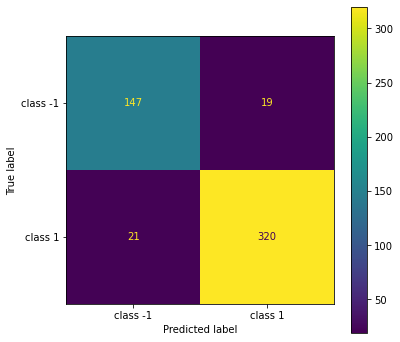

In [10]:
clf_report_with_cm(y_test, y_pred)

# Execution

In [11]:
def load_predict_model(to_pred):
    """Load the model from disk and predict"""
    
    filename = "binary_clf_model.sav"
    loaded_model = joblib.load(filename)

    predicted = loaded_model.predict(to_pred)
    
    return predicted

In [12]:
test_y = load_predict_model(test_X_array)

In [15]:
test_y_df = pd.DataFrame(test_y)
test_y_df.to_csv("project_data/test_labels.csv")

In [16]:
test_y_df

,0
0,1
1,1
2,1
3,1
4,1
...,...
3745,-1
3746,1
3747,1
3748,1
